# Ознакомление с данными

In [317]:
import os
import pandas as pd
import numpy as np

DATA_DIR = '../data/'
RAW_DATA_DIR = os.path.join(DATA_DIR, 'raw')
RAW_DATA_FILE = 'Raifdata.csv'

In [302]:
data = pd.read_csv(os.path.join(RAW_DATA_DIR, RAW_DATA_FILE), index_col=0, low_memory=False)
data['transaction_data'] = pd.to_datetime(data['transaction_date'])

In [303]:
data.head()

,amount,atm_address,atm_address_lat,atm_address_lon,city,country,currency,customer_id,home_add_lat,home_add_lon,mcc,pos_address,pos_adress_lat,pos_adress_lon,terminal_id,transaction_date,work_add_lat,work_add_lon,transaction_data
0,2.884034,NaN,NaN,NaN,ST PETERSBURG,RUS,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5261,NaN,59.844072,30.179153,11606fde0c814ce78e0d726e39a0a5ee,2017-07-15,59.847,30.177,2017-07-15
3,2.787498,NaN,NaN,NaN,ST PETERSBURG,RUS,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5261,NaN,59.844072,30.179153,6c5e5793ebc984fb72875feffff62854,2017-09-09,59.847,30.177,2017-09-09
4,2.892510,NaN,NaN,NaN,ST PETERSBURG,RUS,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5261,NaN,59.844072,30.179153,0576445d74e374c92c0902e612fca356,2017-07-06,59.847,30.177,2017-07-06
5,2.909018,NaN,NaN,NaN,ST PETERSBURG,RUS,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5261,NaN,59.844072,30.179153,af0d099257ccedbfe730c63a491e0d84,2017-08-23,59.847,30.177,2017-08-23
6,2.801228,NaN,NaN,NaN,ST PETERSBURG,RUS,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5261,NaN,59.844072,30.179153,0576445d74e374c92c0902e612fca356,2017-07-29,59.847,30.177,2017-07-29


In [304]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1047190 entries, 0 to 1224733
Data columns (total 19 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   amount            1047190 non-null  float64       
 1   atm_address       217032 non-null   object        
 2   atm_address_lat   148956 non-null   float64       
 3   atm_address_lon   148956 non-null   float64       
 4   city              1047182 non-null  object        
 5   country           1047190 non-null  object        
 6   currency          1047190 non-null  float64       
 7   customer_id       1047190 non-null  object        
 8   home_add_lat      1047176 non-null  float64       
 9   home_add_lon      1047176 non-null  float64       
 10  mcc               1047190 non-null  int64         
 11  pos_address       803539 non-null   object        
 12  pos_adress_lat    819103 non-null   float64       
 13  pos_adress_lon    819103 non-null   float6

## Поиск пропущенных значений в основных столбцах

основные столбцы -
* сумма
* код операции
* дата операции
* id кастомера
* валюта

In [305]:
data[['amount', 'mcc', 'transaction_date', 'customer_id', 'currency']].isna().sum(axis=1).sum()

0

## Для ознакомления используем только операции в рублях

In [306]:
customers_transactions = data[data['currency'] == 643][['customer_id', 'amount', 'currency']].groupby(['customer_id', 'currency'], as_index=False).agg(
    sum_of_transactions = pd.NamedAgg(column='amount', aggfunc='sum'),
    count_of_transactions = pd.NamedAgg(column='amount', aggfunc='count'),
    mean_transaction = pd.NamedAgg(column='amount', aggfunc='mean')
)
customers_transactions.reset_index(inplace=True)
customers_transactions.describe()

,index,currency,sum_of_transactions,count_of_transactions,mean_transaction
count,9987.000000,9987.0,9987.000000,9987.000000,9987.000000
mean,4993.000000,643.0,293.646247,104.312406,2.890237
std,2883.142903,0.0,264.759167,98.274782,0.398272
min,0.000000,643.0,2.083594,1.000000,0.365772
25%,2496.500000,643.0,106.552307,36.000000,2.646048
50%,4993.000000,643.0,214.994652,74.000000,2.872637
75%,7489.500000,643.0,400.827486,142.000000,3.123133
max,9986.000000,643.0,4309.331195,1639.000000,4.948935


## Используем 50% процентиль для достаточного количества транзакий сделанного одним пользователем

In [307]:
customers_transactions = customers_transactions[customers_transactions['count_of_transactions'] >= 74]

In [308]:
data = pd.merge(data, customers_transactions[['customer_id']], how='inner')

## Подключаем группы mcc-кодов

In [309]:
import json
with open(os.path.join(DATA_DIR, 'processed', 'mcc_dict.json'), 'r', encoding='UTF-8') as mcc_json:
    mcc_dict = json.load(mcc_json)

mcc_data = pd.DataFrame(data=mcc_dict).T.reset_index()
mcc_data['index'] = mcc_data['index'].astype('int64')

In [310]:
data = pd.merge(data, mcc_data, left_on='mcc', right_on='index', how='inner')

# Рассмотрим транзакции по группам

## Обзор транзакций пользователей по группам

In [311]:
customer_groups = data[['customer_id', 'amount', 'group', 'transaction_date']].groupby(['customer_id', 'group']).agg(
    count_transactions = pd.NamedAgg(column='amount', aggfunc='count'),
    mean_transactions = pd.NamedAgg(column='amount', aggfunc='mean'),
    sum_transactions = pd.NamedAgg(column='amount', aggfunc='sum'),
    start_date = pd.NamedAgg(column='transaction_date', aggfunc='min'),
    end_date = pd.NamedAgg(column='transaction_date', aggfunc='max')
)
customer_groups.reset_index(inplace=True)

In [312]:
customer_groups.sample(n=15)

,customer_id,group,count_transactions,mean_transactions,sum_transactions,start_date,end_date
31857,b310f91f10a4c51ecf2b4b34cd52f204,V ДЕНЬГИ,51,3.436352,175.253937,2017-02-04,2017-09-23
17665,62de1eff09fab9fd79d370ade8327748,IV-bis ЧТОБ КРАСИВО,8,3.564122,28.512975,2017-04-27,2017-08-16
34492,ca0c5f089611203ea19a84e87eb41ad0,II ОДЕЖДА,1,3.171247,3.171247,2017-04-29,2017-04-29
29972,a8a890b64aafbf5354f1b0797839242f,I ПИЩА,64,3.017960,193.149461,2017-04-03,2017-09-29
11139,3e3f225ff785f1a501246713902d2175,IV ЗДОРОВЬЕ,9,2.936024,26.424218,2017-05-30,2017-09-29
36384,dc8acb5a3fdaf7192b8d4dfaec5453a3,II ОДЕЖДА,7,3.436268,24.053873,2017-04-24,2017-06-20
19960,6f29a7ad9e6c190e0b0ce17bca68fa63,IX ТЕЛЕКОМ,5,3.058550,15.292751,2017-04-02,2017-09-29
29388,a52acb070a9f7251f7dc783d5803bc45,X РАЗВЛЕЧЕНИЯ,6,2.243663,13.461980,2017-04-08,2017-08-18
20460,71ab6ef82a69d2a81d7244a853fea2fb,VI ТРАНСПОРТ И ПУТЕШЕСТВИЯ,58,2.592797,150.382203,2017-04-07,2017-09-30
32188,b4d1fe65ccaf627372bc3c6f8adb2324,III ЖИЛЬЁ,9,1.831005,16.479042,2017-04-04,2017-08-31


## Среднее значение разовой транзакции пользователей по группам

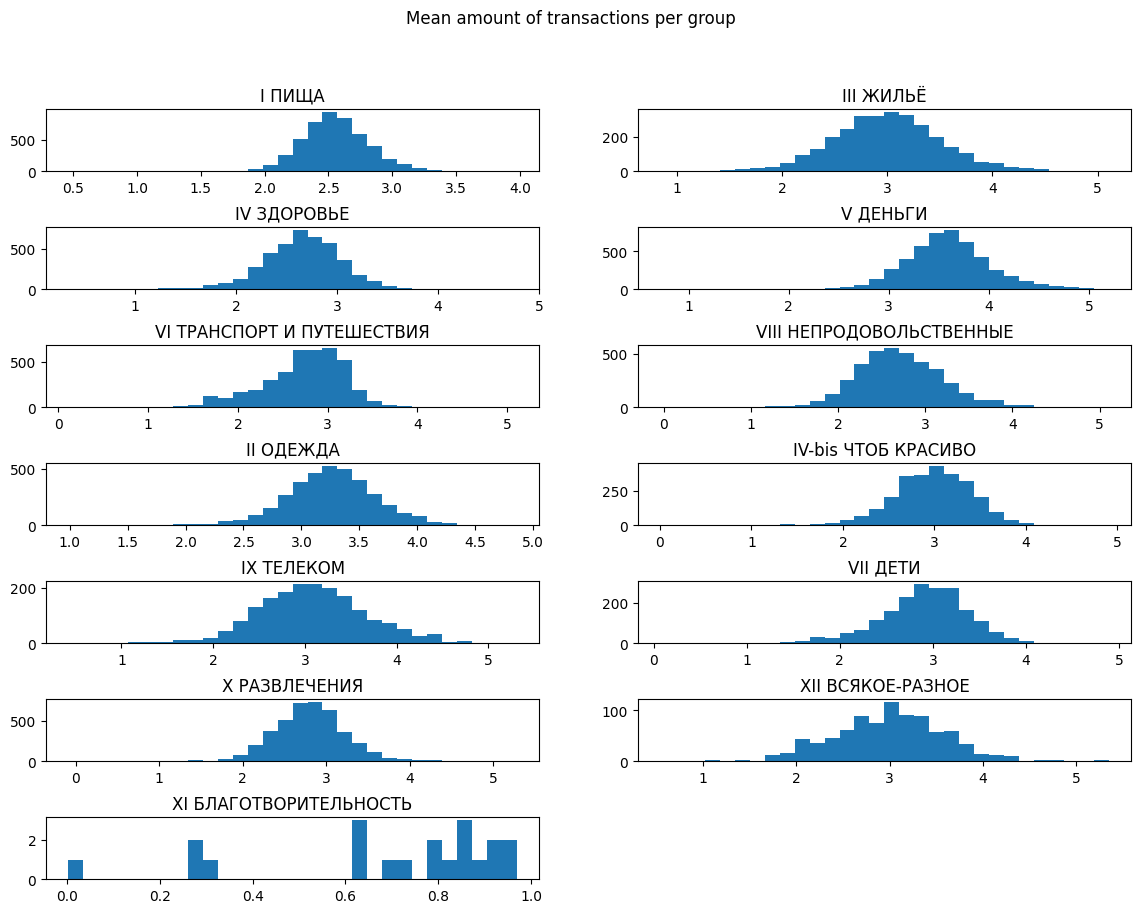

In [313]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(14, 10))
fig.suptitle('Mean amount of transactions per group')
for index, group in enumerate(pd.unique(customer_groups['group'])):
    ax = fig.add_subplot(7, 2, index + 1)
    ax.hist(
        customer_groups[customer_groups['group'] == group][['mean_transactions']],
        bins=30
    )
    ax.set_title(group)
fig.subplots_adjust(wspace=0.2, hspace=0.9)

fig.savefig("../reports/figures/mean_amount_of_transactions_per_group.png")


## Распределение количества транзакций по группам

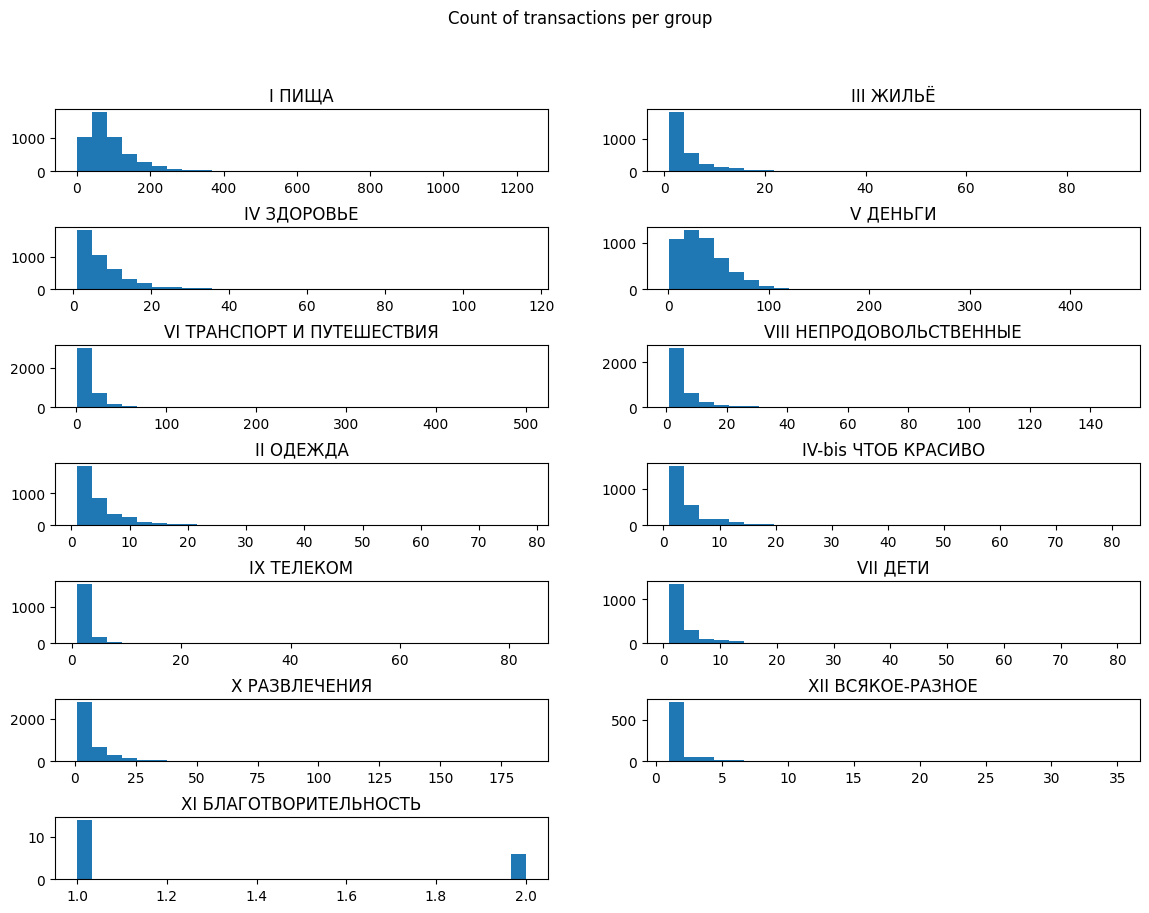

In [314]:
fig = plt.figure(figsize=(14, 10))
fig.suptitle('Count of transactions per group')
for index, group in enumerate(pd.unique(customer_groups['group'])):
    ax = fig.add_subplot(7, 2, index + 1)
    ax.hist(
        customer_groups[customer_groups['group'] == group][['count_transactions']],
        bins=30
    )
    ax.set_title(group)
fig.subplots_adjust(wspace=0.2, hspace=0.9)

fig.savefig("../reports/figures/count_of_transactions_per_group.png")

## Распределение интервала покупок пользователей по группам

In [315]:
user_groups = data[['customer_id', 'group', 'amount', 'transaction_date']]\
    .groupby(by=['customer_id', 'group', 'transaction_date'], as_index=False)\
    .agg(amount=pd.NamedAgg(column='amount', aggfunc='sum'))\
    .sort_values(by=['customer_id', 'group', 'transaction_date'])
user_groups.head()

,customer_id,group,transaction_date,amount
0,0001f322716470bf9bfc1708f06f00fc,I ПИЩА,2017-05-05,2.347082
1,0001f322716470bf9bfc1708f06f00fc,I ПИЩА,2017-05-21,1.949756
2,0001f322716470bf9bfc1708f06f00fc,I ПИЩА,2017-06-10,2.407830
3,0001f322716470bf9bfc1708f06f00fc,I ПИЩА,2017-06-11,2.320913
4,0001f322716470bf9bfc1708f06f00fc,I ПИЩА,2017-06-13,3.460175


In [324]:
user_groups.loc[:, 'transaction_date'] = pd.to_datetime(user_groups.transaction_date)
user_groups_date_diff = user_groups.groupby(by=['customer_id', 'group'], as_index=False).agg(
    date_dif=pd.NamedAgg(column='transaction_date', aggfunc=lambda x: np.mean(x[1:].values - x[0:-1].values)),
    mean_amount=pd.NamedAgg(column="amount", aggfunc='mean')
)
user_groups_date_diff = user_groups_date_diff[~user_groups_date_diff['date_dif'].isna()]
user_groups_date_diff['date_dif'] = user_groups_date_diff['date_dif'].apply(lambda x: x.seconds //60 // 60 + x.days * 24)
user_groups_date_diff.head(n=20)

/home/alexey/PycharmProjects/sber-itmo-raif/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alexey/PycharmProjects/sber-itmo-raif/venv/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: divide by zero encountered in divide
  ret = ret.dtype.type(ret / rcount)


,customer_id,group,date_dif,mean_amount
0,0001f322716470bf9bfc1708f06f00fc,I ПИЩА,296,2.400936
3,0001f322716470bf9bfc1708f06f00fc,V ДЕНЬГИ,128,4.171097
4,0001f322716470bf9bfc1708f06f00fc,VI ТРАНСПОРТ И ПУТЕШЕСТВИЯ,715,2.995914
5,0001f322716470bf9bfc1708f06f00fc,VIII НЕПРОДОВОЛЬСТВЕННЫЕ,504,2.594479
6,0007297d86e14bd68bd87b1dbdefe302,I ПИЩА,58,4.109599
7,0007297d86e14bd68bd87b1dbdefe302,II ОДЕЖДА,1128,2.996828
9,0007297d86e14bd68bd87b1dbdefe302,IV ЗДОРОВЬЕ,471,2.681114
10,0007297d86e14bd68bd87b1dbdefe302,IV-bis ЧТОБ КРАСИВО,3168,2.655285
11,0007297d86e14bd68bd87b1dbdefe302,IX ТЕЛЕКОМ,1224,3.317505
12,0007297d86e14bd68bd87b1dbdefe302,V ДЕНЬГИ,132,3.946210


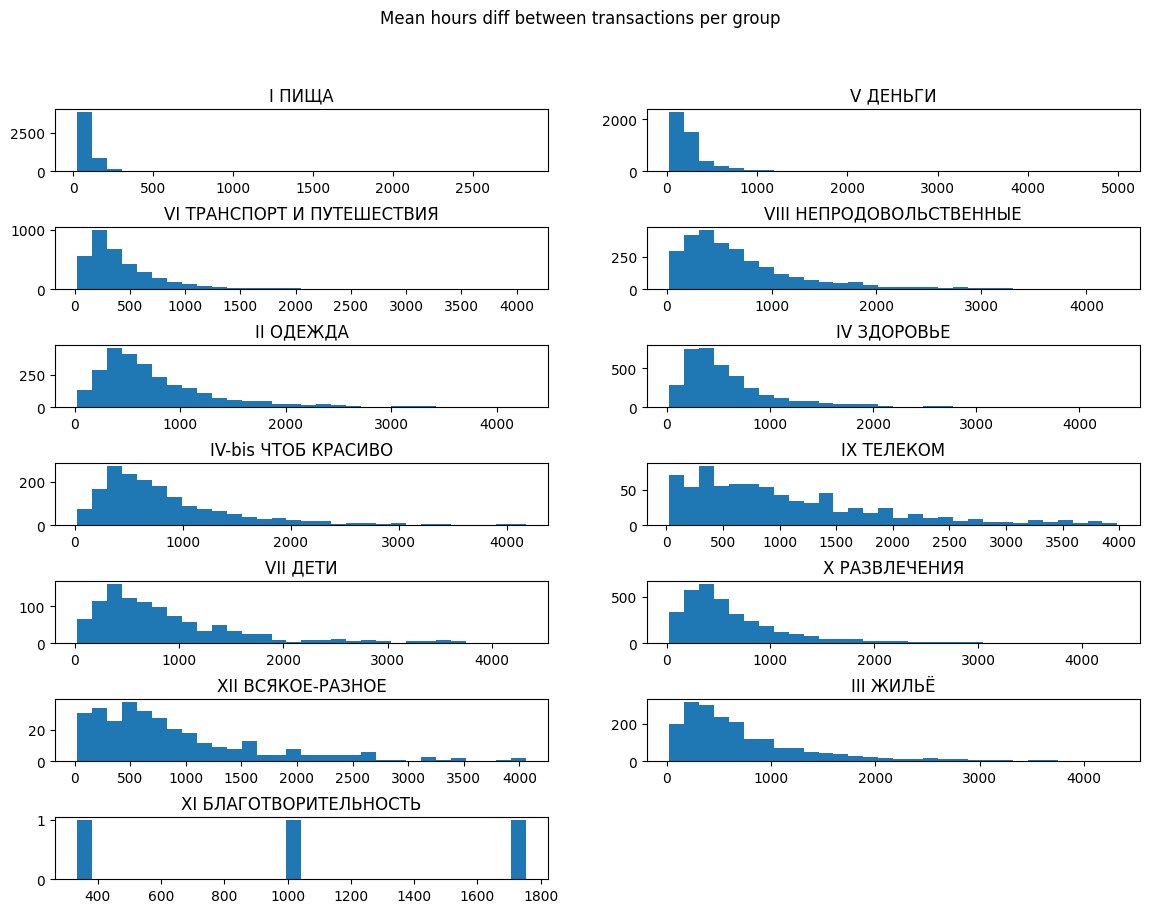

In [330]:
fig = plt.figure(figsize=(14, 10))
fig.suptitle('Mean hours diff between transactions per group')
for index, group in enumerate(pd.unique(user_groups_date_diff['group'])):
    ax = fig.add_subplot(7, 2, index + 1)
    ax.hist(
        user_groups_date_diff[user_groups_date_diff['group'] == group][['date_dif']],
        bins=30
    )
    ax.set_title(group)
fig.subplots_adjust(wspace=0.2, hspace=0.9)

fig.savefig("../reports/figures/hours_dif_of_transactions_per_group.png")

## Распределение сумм трат пользователей по группам в зависимости от давности последней покупки

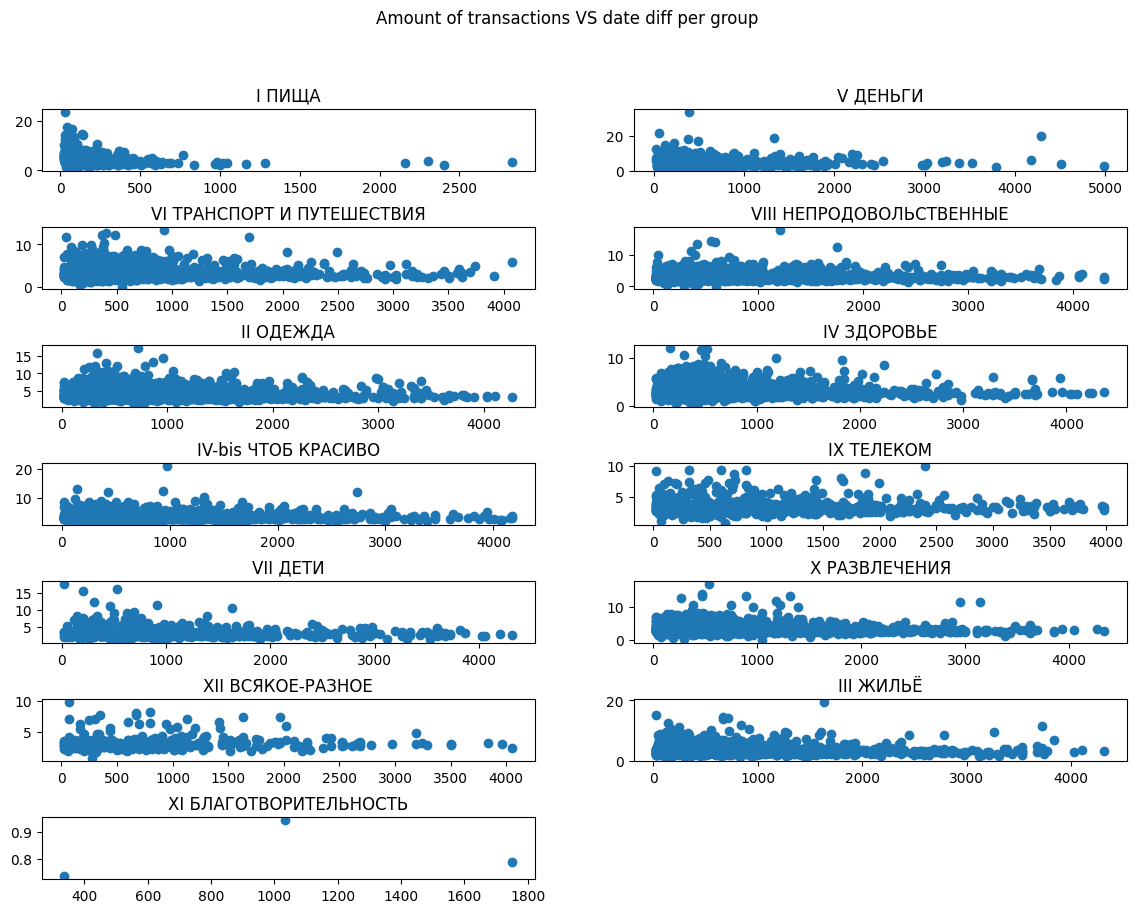

In [332]:
fig = plt.figure(figsize=(14, 10))
fig.suptitle('Amount of transactions VS date diff per group')
for index, group in enumerate(pd.unique(user_groups_date_diff['group'])):
    ax = fig.add_subplot(7, 2, index + 1)
    ax.scatter(
        user_groups_date_diff[user_groups_date_diff['group'] == group][['date_dif']],
        user_groups_date_diff[user_groups_date_diff['group'] == group][['mean_amount']]
    )
    ax.set_title(group)
fig.subplots_adjust(wspace=0.2, hspace=0.9)

fig.savefig("../reports/figures/hours_dif_VS_amount_of_transactions_per_group.png")

## Распределение количества и сумм транзакций пользователей по месяцам

In [326]:
week_transactions_per_group = user_groups.groupby(by=['group', pd.Grouper(key='transaction_date', freq='1M')])\
    .agg(
    count_of_transactions=pd.NamedAgg(column='amount', aggfunc='count'),
    amount_of_transactions=pd.NamedAgg(column='amount', aggfunc='sum'),
)
week_transactions_per_group.reset_index(inplace=True)
week_transactions_per_group.head()

,group,transaction_date,count_of_transactions,amount_of_transactions
0,I ПИЩА,2017-04-30,45499,176853.433403
1,I ПИЩА,2017-05-31,48464,189329.534903
2,I ПИЩА,2017-06-30,50901,208533.584396
3,I ПИЩА,2017-07-31,51188,209719.926224
4,I ПИЩА,2017-08-31,49544,200689.275054


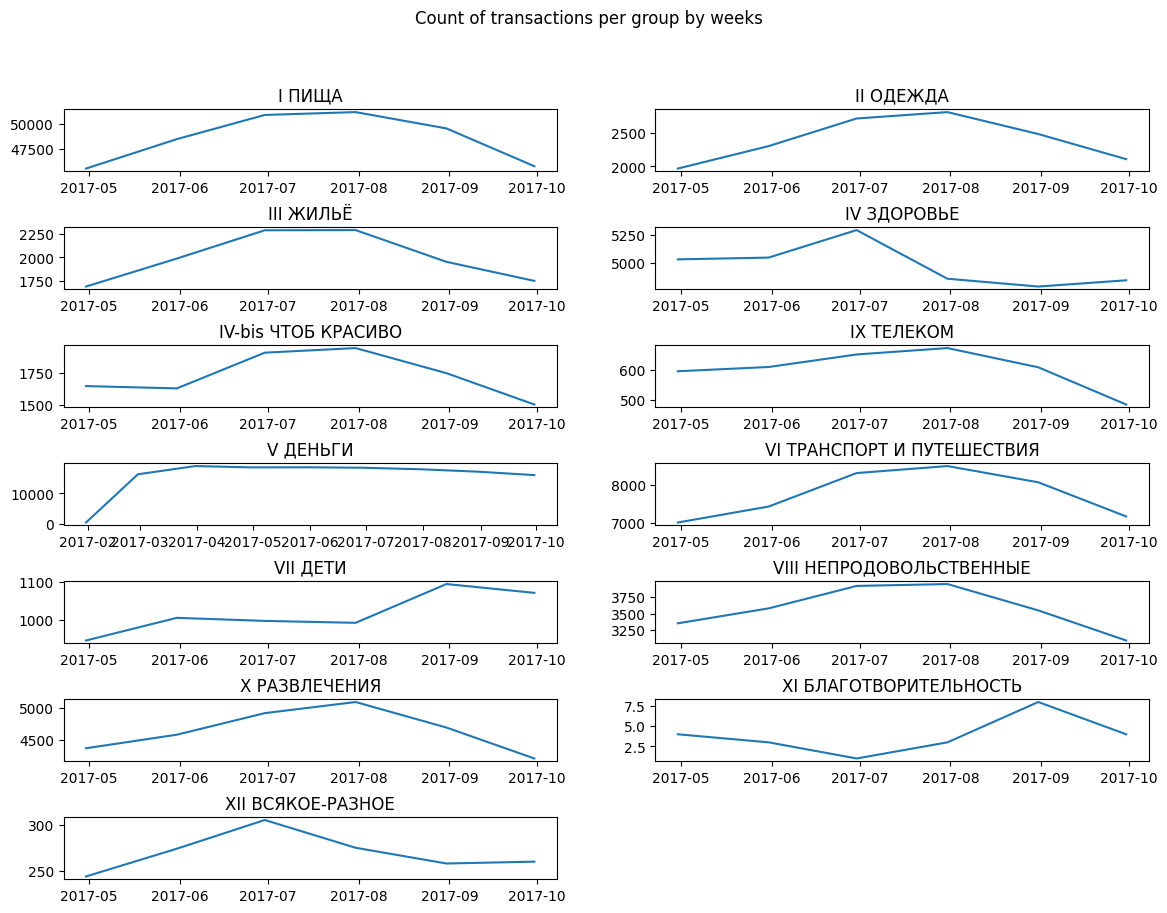

In [327]:
fig = plt.figure(figsize=(14, 10))
fig.suptitle('Count of transactions per group by weeks')
for index, group in enumerate(pd.unique(week_transactions_per_group['group'])):
    ax = fig.add_subplot(7, 2, index + 1)
    ax.plot(
        week_transactions_per_group[week_transactions_per_group['group'] == group][['transaction_date']],
        week_transactions_per_group[week_transactions_per_group['group'] == group][['count_of_transactions']]
    )
    ax.set_title(group)

fig.subplots_adjust(wspace=0.2, hspace=0.9)
fig.savefig("../reports/figures/count_of_transactions_per_group_by_month.png")

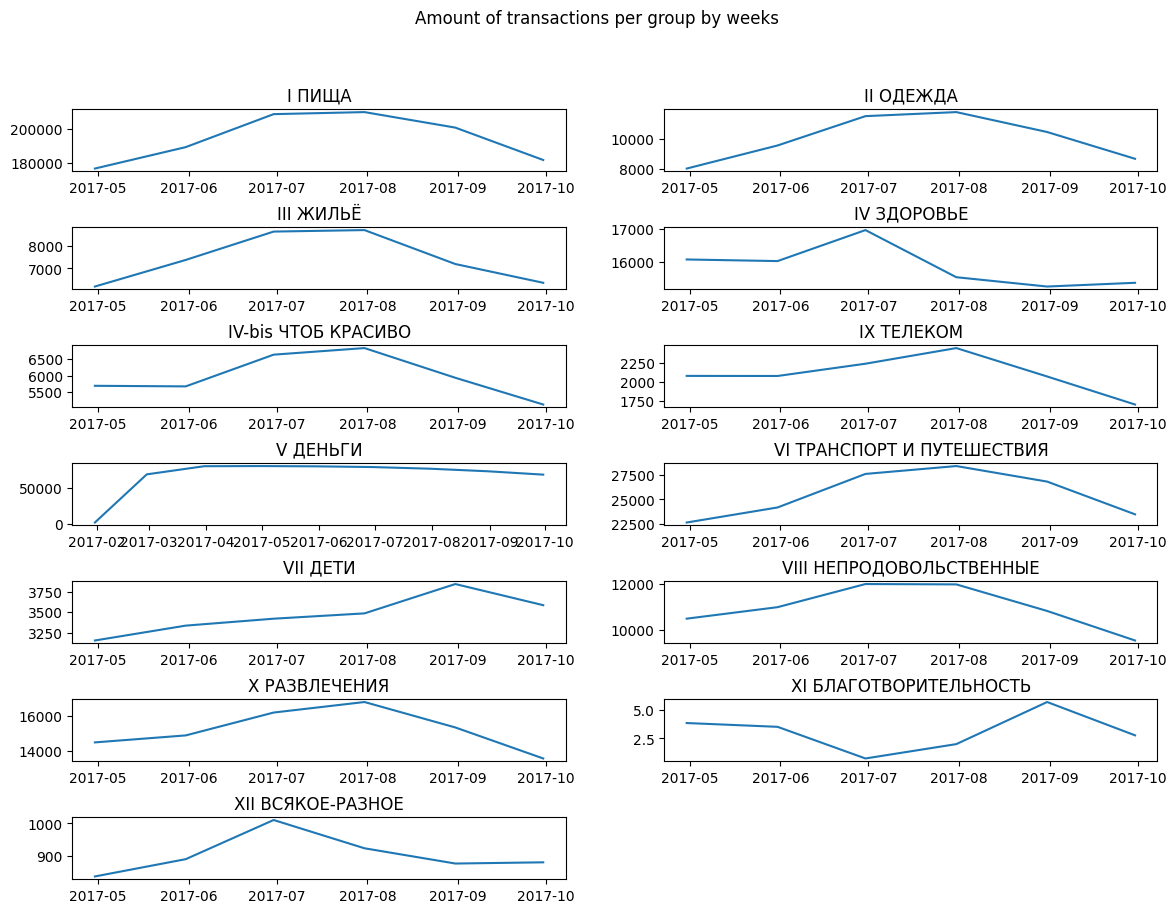

In [328]:
fig = plt.figure(figsize=(14, 10))
fig.suptitle('Amount of transactions per group by weeks')
for index, group in enumerate(pd.unique(week_transactions_per_group['group'])):
    ax = fig.add_subplot(7, 2, index + 1)
    ax.plot(
        week_transactions_per_group[week_transactions_per_group['group'] == group][['transaction_date']],
        week_transactions_per_group[week_transactions_per_group['group'] == group][['amount_of_transactions']]
    )
    ax.set_title(group)

fig.subplots_adjust(wspace=0.2, hspace=0.9)
fig.savefig("../reports/figures/amount_of_transactions_per_group_by_month.png")